In [45]:
import numpy as np
import pandas as pd
import matplotlib as plt
import types
import io
from botocore.client import Config
import ibm_boto3
import seaborn as sb
sb.set() # set the default Seaborn style for graphics

# Importing the CSV data from IBM Cloud Object Storage

In [46]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-6c8a381c-1c95-4193-be32-9da6d151ea30',
    'IBM_API_KEY_ID': 'LGsMSNTh4EWfQG2FBljBmrk_DJqKt9Ehnmde6vyx0SJH',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'scdfxibm-donotdelete-pr-bhgaadhboclg0t',
    'FILE': 'SCDF_dataset1.csv'
}

In [47]:
def __iter__(self): return 0

client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [48]:
n_datasets = 5
dfs = []

for i in range(n_datasets):
    body = client.get_object(Bucket=credentials['BUCKET'],Key='SCDF_dataset%i.csv'%(i+1))['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    df_time = pd.read_csv(body, header=0, parse_dates=[0], index_col=0, squeeze=True)
    dfs.append(df_time.copy())

## Sliding Window Algorithm

In [49]:
def get_window(minutes = 15):
    output = [] 
    for i in range(n_datasets):
        df = dfs[i].rolling('%imin'%(minutes)).mean()
        start_time = df.index[0] + pd.Timedelta('%imin'%(minutes))
        df = df[start_time:].dropna()
        df = df.reset_index()
        df = df.iloc[:,1:]
        output.append(df.copy())
    return pd.concat(output, ignore_index=True)

In [50]:
#construct dataframes for each window timeframe. we will only use the 10 min window for this demo
df_10min = get_window(10)
df_30min = get_window(30)
df_60min = get_window(60)

In [51]:
df_10min.tail()

,Ext Temp,Humidity,Core Temp,Heart Rate,Breathing Rate,PSI
3000,39.500833,94.600,37.839167,134.708333,32.308333,6.838333
3001,39.505000,94.550,37.837500,134.700000,32.308333,6.833333
3002,39.500000,94.625,37.835000,134.666667,32.333333,6.839167
3003,39.498333,94.700,37.837500,134.641667,32.341667,6.838333
3004,39.498333,94.725,37.838333,134.658333,32.366667,6.832500


In [52]:
df_30min.tail()

,Ext Temp,Humidity,Core Temp,Heart Rate,Breathing Rate,PSI
1800,39.491389,94.886111,38.316111,139.947222,37.888889,7.684722
1801,39.493333,94.863889,38.313889,139.947222,37.880556,7.682500
1802,39.494444,94.891667,38.313333,139.933333,37.880556,7.681389
1803,39.495000,94.905556,38.313611,139.916667,37.875000,7.681111
1804,39.495833,94.927778,38.313889,139.908333,37.872222,7.679444


In [53]:
df_60min.tail()

,Ext Temp,Humidity,Core Temp,Heart Rate,Breathing Rate,PSI
0,35.513472,85.075000,37.545972,125.691667,31.927778,6.742500
1,32.504167,55.020833,37.325278,121.823611,31.091667,6.556528
2,29.477083,64.761111,37.257361,120.487500,30.919444,6.576389
3,25.513889,74.916667,37.205417,125.766667,31.755556,6.377083
4,39.495833,95.001389,38.027361,134.888889,35.269444,7.132778


# Training the Model: Multivariate Anomaly Detection

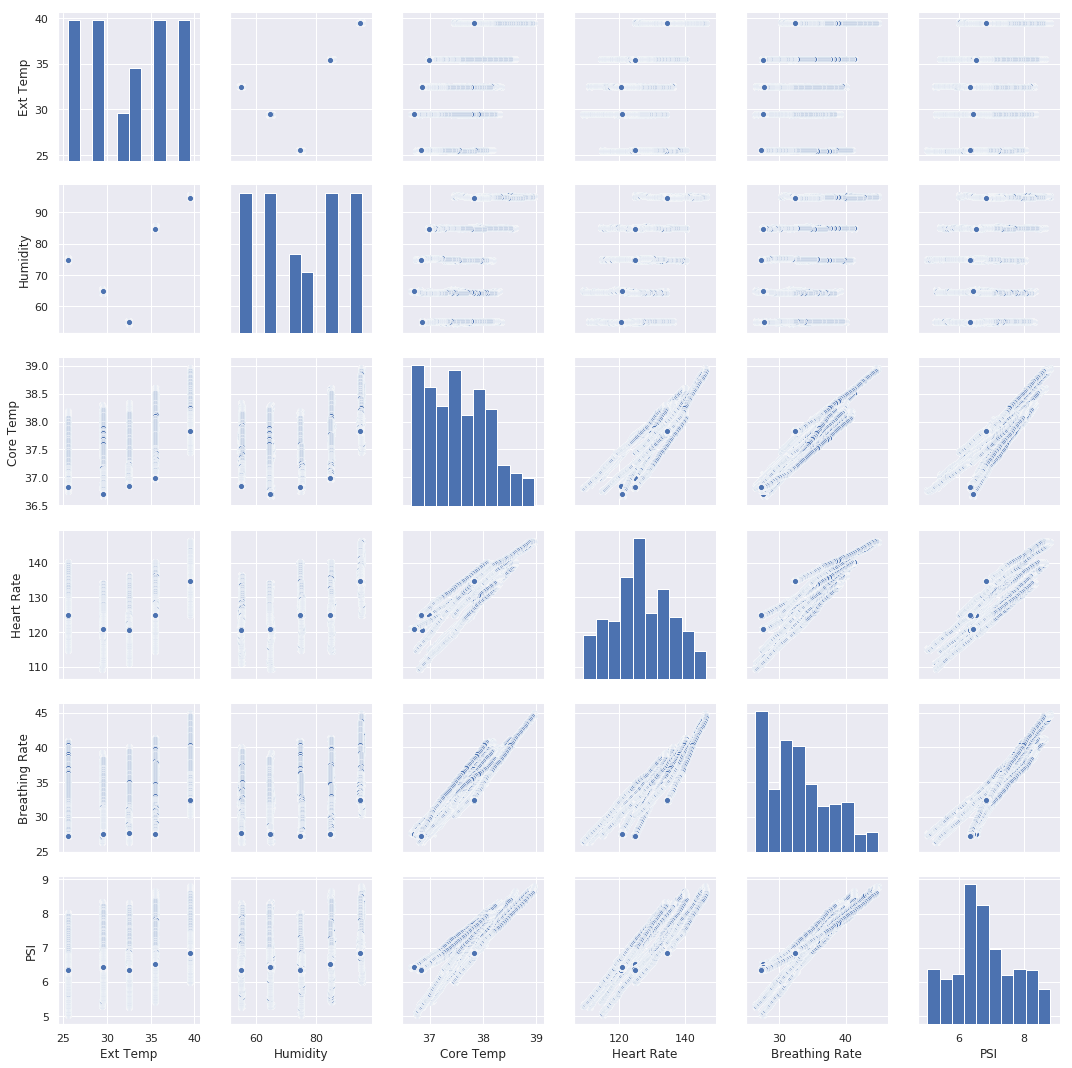

In [54]:
# Extract the Features from the Data
X = pd.DataFrame(df_10min[["Ext Temp", "Humidity", "Core Temp", "Heart Rate", "Breathing Rate", "PSI"]]) 

# Plot the Raw Data on 2D grids
sb.pairplot(X)

In [55]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Set the Parameters for Neighborhood
num_neighbors = 10      # Number of Neighbors
cont_fraction = 0.00025    # Fraction of Anomalies

# Create Anomaly Detection Model using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies
lof.fit(X)

LocalOutlierFactor(algorithm='auto', contamination=0.00025, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=10, novelty=False, p=2)

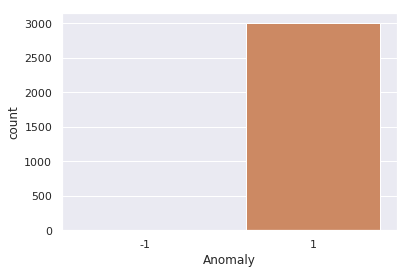

In [56]:
# Predict the Anomalies
labels = lof.fit_predict(X)

# Append Labels to the Data
X_labeled = X.copy()
X_labeled["Anomaly"] = pd.Categorical(labels)

# Summary of the Anomaly Labels
sb.countplot(X_labeled["Anomaly"])

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


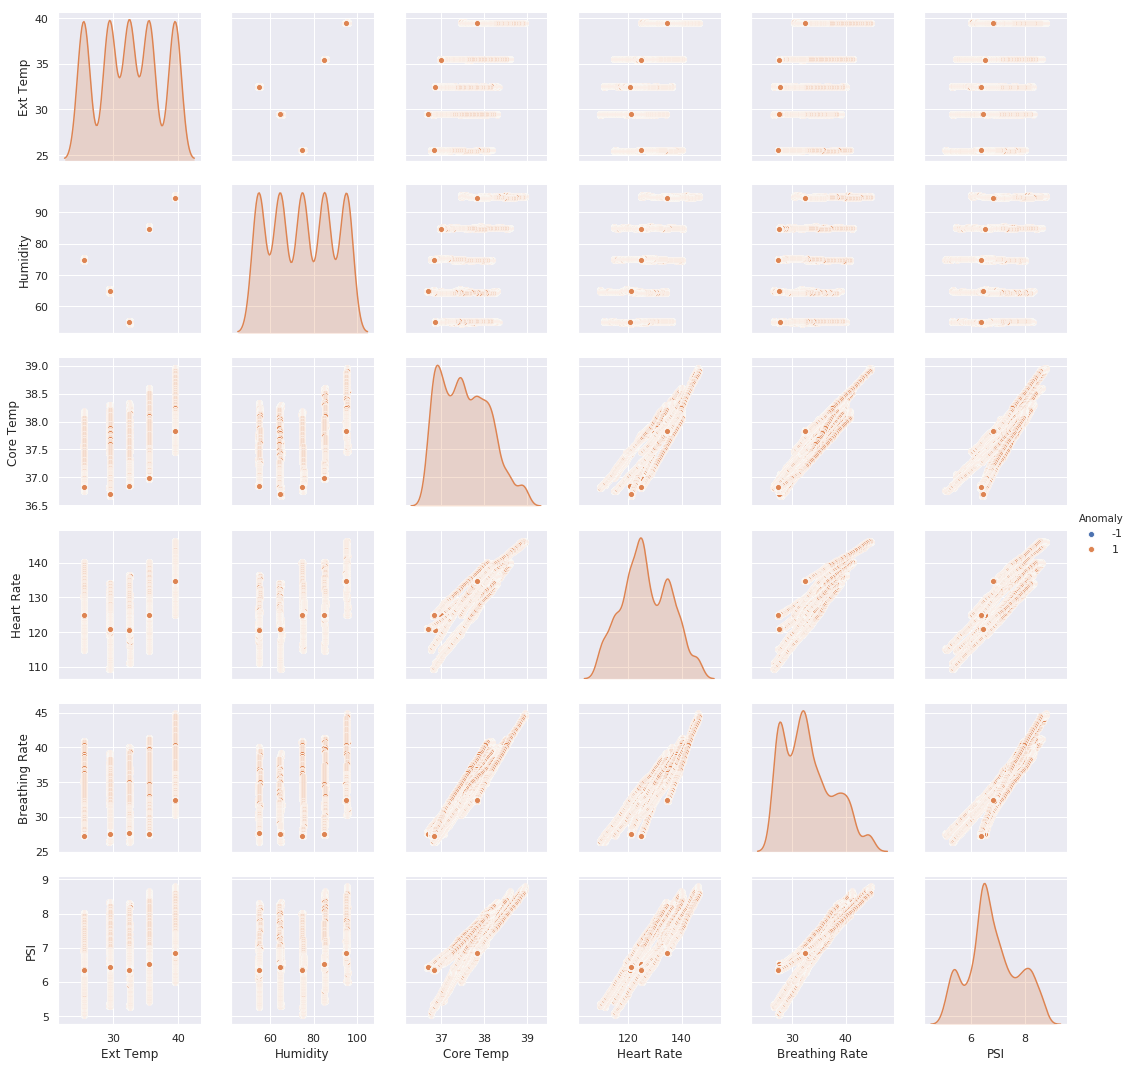

In [57]:
# Visualize the Anomalies in the Data
sb.pairplot(X_labeled, vars = X.columns.values, hue = "Anomaly")

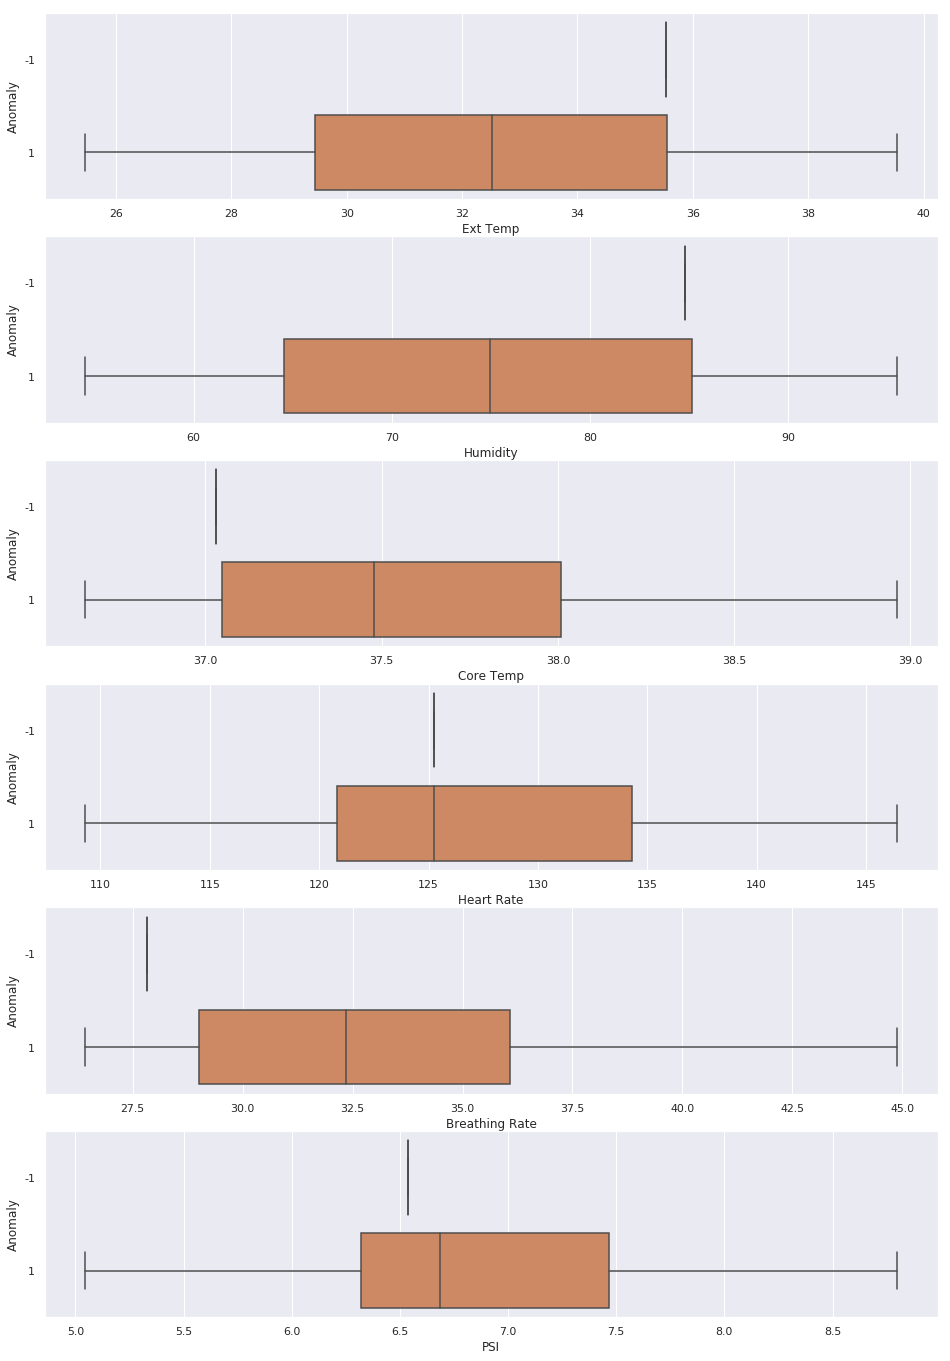

In [58]:
# Boxplots for all Features against the Anomalies
f, axes = plt.pyplot.subplots(6, 1, figsize=(16,24))
sb.boxplot(x = 'Ext Temp', y = 'Anomaly', data = X_labeled, ax = axes[0])
sb.boxplot(x = 'Humidity', y = 'Anomaly', data = X_labeled, ax = axes[1])
sb.boxplot(x = 'Core Temp', y = 'Anomaly', data = X_labeled, ax = axes[2])
sb.boxplot(x = 'Heart Rate', y = 'Anomaly', data = X_labeled, ax = axes[3])
sb.boxplot(x = 'Breathing Rate', y = 'Anomaly', data = X_labeled, ax = axes[4])
sb.boxplot(x = 'PSI', y = 'Anomaly', data = X_labeled, ax = axes[5])

# Testing the Model

In [59]:
#Load test dataset
body = client.get_object(Bucket=credentials['BUCKET'],Key='SCDF_dataset_test1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )


real_time_data = pd.read_csv(body,  header=0, parse_dates=[0], index_col=0, squeeze=True)
real_time_data.head()

,Ext Temp,Humidity,Core Temp,Heart Rate,Breathing Rate,PSI
Time,,,,,,
2020-06-14 00:00:00,25.4,75,37.4,124,33,5.8
2020-06-14 00:00:05,25.6,75,37.6,124,32,6.4
2020-06-14 00:00:10,25.4,80,37.6,128,29,6.4
2020-06-14 00:00:15,25.6,77,37.4,121,29,6.5
2020-06-14 00:00:20,25.4,75,37.7,124,33,6.4


In [60]:
#To continuous update data to the nearest 10mins
def sliding_window(test_df, minutes = 15):
    df = test_df.rolling('%imin'%(minutes)).mean()
    #start_time = df.index[0] + pd.Timedelta('%imin'%(minutes))
    #df = df[start_time:].dropna()
    df = df.dropna()
    df = df.reset_index()
    df = df.iloc[:,1:]
    return df

In [61]:
real_time_data = sliding_window(real_time_data, 10)
real_time_data.head()

,Ext Temp,Humidity,Core Temp,Heart Rate,Breathing Rate,PSI
0,25.400000,75.000000,37.400000,124.000000,33.000000,5.800
1,25.500000,75.000000,37.500000,124.000000,32.500000,6.100
2,25.466667,76.666667,37.533333,125.333333,31.333333,6.200
3,25.500000,76.750000,37.500000,124.250000,30.750000,6.275
4,25.480000,76.400000,37.540000,124.200000,31.200000,6.300


In [62]:
#Predicting on real time dataset
clf = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination=cont_fraction)
clf.fit(X)


LocalOutlierFactor(algorithm='auto', contamination=0.00025, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=10, novelty=True, p=2)

In [111]:
#Check for anomaly
anomaly_or_not = clf.predict(real_time_data)

#Check for counter limit
counter = 0
counterLimit = 10

for i in range(0, anomaly_or_not.size):
    if (anomaly_or_not[i] == -1):
        print("Anomaly has been detected")
        counter += 1
        if counter >= counterLimit:
            print("Limit has been reach at datapoint", i, "at time =", i*5, "s")
    else:
        counter = 0


# if anomaly_or_not[0] <0:
#     print("Anomaly signs detected! First responder might be overexerting!")
# else:
#     print("All is well!")

Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected
Limit has been reach at datapoint 188 at time = 940 s
Anomaly has been detected
Limit has been reach at datapoint 189 at time = 945 s
Anomaly has been detected
Limit has been reach at datapoint 190 at time = 950 s
Anomaly has been detected
Limit has been reach at datapoint 191 at time = 955 s
Anomaly has been detected
Limit has been reach at datapoint 192 at time = 960 s
Anomaly has been detected
Limit has been reach at datapoint 193 at time = 965 s
Anomaly has been detected
Anomaly has been detected
Anomaly has been detected


If anomaly is detected consecutive for 50 seconds (10 rolling datapoints), first responder is to be extracted

## Visualise test data

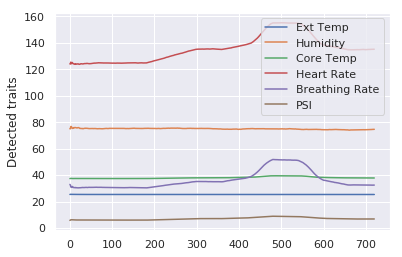

In [64]:
#Line graph of average data in a rolling 10 min frame
import matplotlib.pyplot as plt
plt.plot(real_time_data)
plt.ylabel('Detected traits')
plt.legend(labels= ["Ext Temp", "Humidity", "Core Temp", "Heart Rate", "Breathing Rate", "PSI"])
plt.show()

We see a clear rise in heart rate and breathing rate from around point 420 - 600. Can our model detect this?

# Visualise anomalies

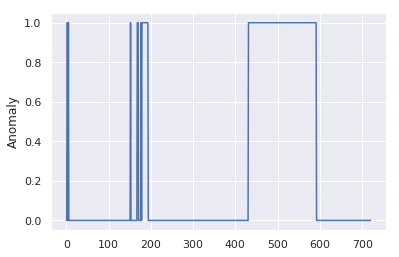

In [65]:
#Graph showing anomaly detected on a rolling 10 min basis
data = clf.predict(real_time_data)
plt.plot((1-data)/2)
plt.ylabel('Anomaly')
plt.show()

Crosscheck with above limit detection and you can see that detection of consecutive anomaly points work.

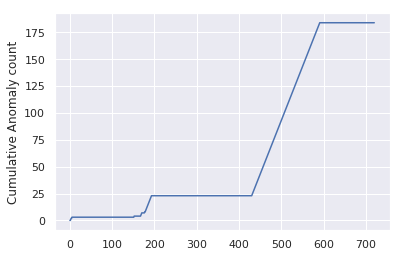

In [66]:
#cumulative plot
new_data = [0]
for i in range(1,len(data)):
    new_data.append(new_data[i-1] + int(data[i] == -1))

plt.plot(new_data)
plt.ylabel('Cumulative Anomaly count')
plt.show()

For example, in the above scenario, the HQ will be notified of the responder's anomalous datapoints at around point 420. 
The model is built to collect data on a rolling 10 min basis. 
The model can be repurposed to collect data on other time intervals(eg.30 min, 1hour) for different operations